# Importing packages

In [1]:
import networkx as nx
import numpy as np
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from collections import Counter

c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing the dataset, making and visualizing the graph

In [2]:
G = nx.karate_club_graph()

Here, we have created the graph of Zachary's Karate Club dataset using the networkx package. Then, using the spring_layout and draw functions from the same library, we plotted this graph with edges of different colors for different clubs.

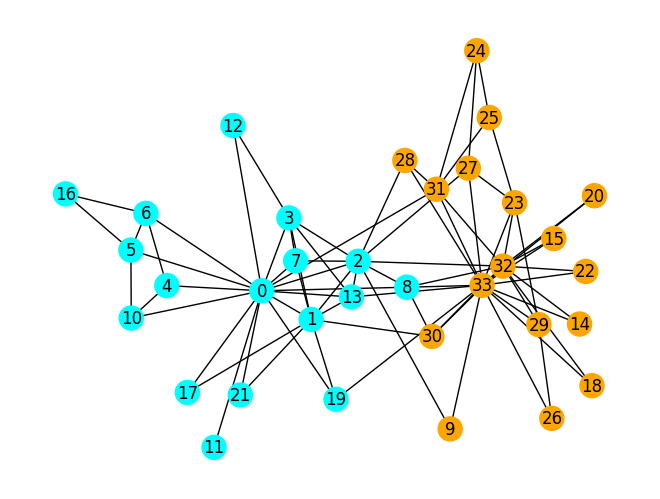

In [3]:
clubs = list(set(nx.get_node_attributes(G, 'club').values()))
color_map = {club: color for club, color in zip(clubs, ['orange', 'cyan'])}
node_colors = [color_map[G.nodes[node]['club']] for node in G.nodes]
pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, node_color=node_colors)
plt.show()

# Graph Exploration
Next, I obtained the number of nodes, number of edges, average degree, density, and clustering coefficient of this graph.

The average degree returns the average of the degrees of the graph's nodes.
Density 

The clustering coefficient is a measure of the tendency of the nodes in a graph to form clusters.
This metric indicates how close the neighbors of a node are to forming a complete graph.
There are three types of clustering coefficients:

#### 1. Local Clustering Coefficient
It indicates whether two neighbors of a node are also neighbors with each other. If the number of neighbors for node $v$ is $k_{v}$ and $e_{v}$ is the number of edges between these neighbors, the local clustering coefficient is:
$$C(v) = \frac{2e_{v}}{k_{v}(k_{v} - 1)}$$
If this coefficient is zero, there are no connections between the neighbors of node $v$. If it is one, it means all neighbors of $v$ are connected to each other.

#### 2. Global Clustering Coefficient
It indicates the overall tendency of the nodes in a graph to form triangles.
It is calculated using the following formula:
$$C_{global} = \frac{\text{Number of closed triangles}}{\text{Number of triangles}}$$

#### 3. Average Clustering Coefficient
It is the average of the local clustering coefficients of all nodes in the graph ($|V|$ is the number of nodes in the graph):
$$C_{avg} = \frac{1}{|V|} \sum_{v \in V} C(v)$$

In the cell below, I obtained the average clustering coefficient using the `average_clustering()` function from the library.

In [4]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degree_avg = sum(dict(G.degree()).values()) / num_nodes
clustering_coefficient = nx.average_clustering(G, weight='weight')

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {degree_avg}")
print(f"Clustering coefficient: {clustering_coefficient}")

Number of nodes: 34
Number of edges: 78
Average degree: 4.588235294117647
Clustering coefficient: 0.24139179950856338


In [5]:
local_clustering_coefficients = nx.clustering(G, weight='weight')
print(f"Local Clustering Coefficients:{local_clustering_coefficients}")

Local Clustering Coefficients:{0: 0.06631121196141879, 1: 0.16691488397650842, 2: 0.13142659927282047, 3: 0.3000014925962803, 4: 0.24959441849608535, 5: 0.23177447626640527, 6: 0.23177447626640527, 7: 0.4856715918928874, 8: 0.24297226992368195, 9: 0, 10: 0.24959441849608535, 11: 0, 12: 0.2971548318645577, 13: 0.3072865570958022, 14: 0.44389035799340837, 15: 0.5592668058812662, 16: 0.5081276149271519, 17: 0.2857142857142857, 18: 0.3077763842902691, 19: 0.11999248094236886, 20: 0.3523160106186386, 21: 0.3599774428271066, 22: 0.44389035799340837, 23: 0.22058508021994944, 24: 0.14459947485122202, 25: 0.14459947485122202, 26: 0.3599774428271066, 27: 0.09523809523809523, 28: 0.11999248094236886, 29: 0.30331335178397195, 30: 0.23473382269963547, 31: 0.09395524239742073, 32: 0.0965676420286808, 33: 0.05233010615463942}


# Node Feature Extraction and Clustering
#### Obtaining Embedding for Each Node Using the Node2vec Algorithm
Graph embedding refers to the process of converting a graph, its nodes, and edges into a low-dimensional vector representation such that the information in the graph is preserved. These vector representations can be used in machine learning tasks such as clustering and classification.

Using embedding, each node in the graph corresponds to a vector in Euclidean space. Nodes with similar roles or structural positions in the graph will have closer embeddings.

The Node2vec algorithm is a graph embedding algorithm inspired by the Word2vec algorithm in natural language processing (NLP).

##### How Node2vec Works
1. Biased Random Walks
First, by simulating random walks on the graph, we create sequences of nodes.
    **Random Walk Process:**
        1-1. Start from a node.
        1-2. Based on a probability distribution that combines features of both BFS and DFS, i.e., local neighborhood exploration and distant area exploration, select the next node.
        **Parameters Managing the Bias:**
            Variable $p$: Controls the likelihood of revisiting the previous node. (Less than one favors revisiting the previous node (like DFS), and more than one resists revisiting the previous node (like BFS).)
            Variable $q$: Controls the likelihood of exploring nodes farther from the starting node. (Less than one favors distant nodes (like DFS), and more than one favors staying close to the starting node (like BFS).)

2. After creating these sequences, we use the skip-gram model from the Word2vec algorithm to build the embeddings. The Word2vec algorithm, by taking sentences as input and using skip-gram, creates ordered pairs (target, context).
![1_A9AySBfSinKVbSYlntcndw.webp](attachment:1_A9AySBfSinKVbSYlntcndw.webp)
Here, by providing these ordered pairs created from the node sequences to the skip-gram model, it creates ordered pairs and then feeds them into a two-layer neural network. Once the training of this neural network is complete, we treat the weights of the hidden layer as the embedding values. The number of neurons in the hidden layer determines the size of the embedding.
![1_IAvi1IEavTmXTxE9uegEfw-1.webp](attachment:1_IAvi1IEavTmXTxE9uegEfw-1.webp)

In [6]:
param_grid = {
    'dimensions': [32, 64, 128],
    'walk_length': [10, 20, 30],
    'num_walks': [50, 100, 200],
}

best_score = -1
best_params = None

for dimensions in param_grid['dimensions']:
    for walk_length in param_grid['walk_length']:
        for num_walks in param_grid['num_walks']:
            node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks)
            model = node2vec.fit()
            
            embeddings = [model.wv[str(node)] for node in G.nodes()]
            
            kmeans = KMeans(n_clusters=5)
            labels = kmeans.fit_predict(embeddings)
            
            score = silhouette_score(embeddings, labels)
            
            if score > best_score:
                best_score = score
                best_params = {
                    'dimensions': dimensions,
                    'walk_length': walk_length,
                    'num_walks': num_walks,
                }

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)

Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 1521.52it/s]


Generating walks (CPU: 1): 100%|██████████| 200/200 [00:01<00:00, 124.66it/s]


Best Parameters: {'dimensions': 128, 'walk_length': 10, 'num_walks': 50}
Best Silhouette Score: 0.60313904


In [7]:
node2vec = Node2Vec(G, dimensions=128, walk_length=10, num_walks=50, workers=4)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}

Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 2293.41it/s]


## Clustering using KMeans algorithm

In [8]:
X = np.array(list(embeddings.values()))

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(X)

print("Cluster labels:", labels)

Cluster labels: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


## Dimension Reduction using T-SNE algorithm (for visualization)

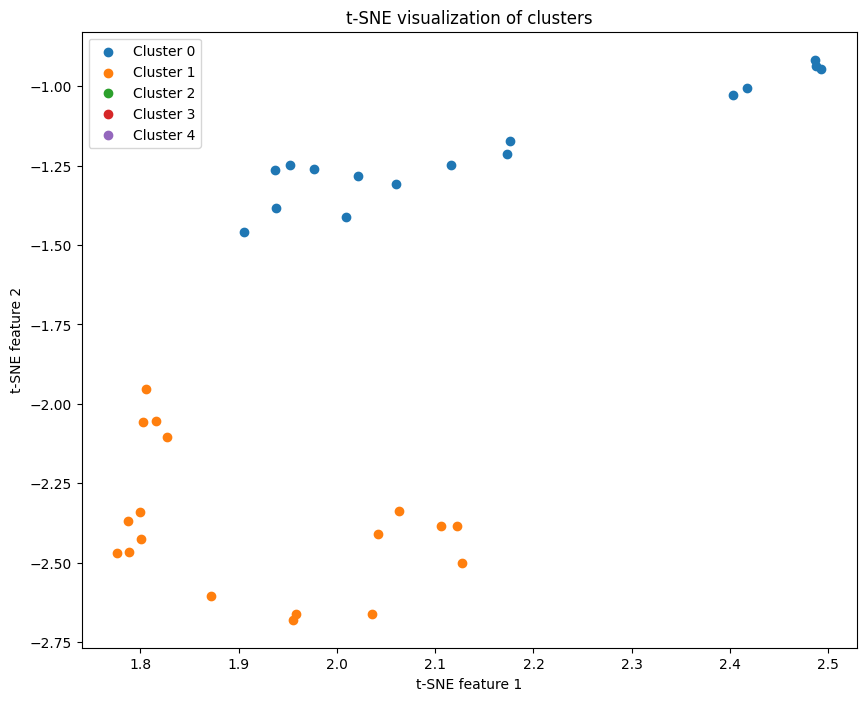

In [9]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
for i in range(5):  # Assuming there are 5 clusters
    plt.scatter(X_tsne[labels == i, 0], X_tsne[labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

### Calculation of Purity
This metric helps us to evaluate the quality of clustering results. Purity measures how homogeneous each cluster is with respect to the ground-truth classes. 

In [10]:
true_labels = [G.nodes[node]['club'] for node in G.nodes()]
clusters = np.unique(labels)

total_correct = 0
for c in clusters:
    idx = np.where(labels == c)[0]
    cluster_clubs = [true_labels[i] for i in idx]
    most_common_count = Counter(cluster_clubs).most_common(1)[0][1]
    total_correct += most_common_count

purity = total_correct / len(labels)
print("Purity:", purity)

Purity: 0.9705882352941176


# Link Prediction
In the final part, the dataset is split in two subsets of train and test. Adamic-Adar score is a link prediction metric which quantifies the similarity between two nodes by summing the inverse logarithm of the degree of each common neighbot. Low-degree nodes contribute more to the score.

With 80% of the edges for train graph, the Adamic-Adar score is calculated for these test edges using NetworkX’s nx.adamic_adar_index function, storing these scores in a dictionary.

In [11]:
G_train = G.copy()

all_edges = list(G_train.edges())
np.random.shuffle(all_edges)

test_size = int(0.2 * len(all_edges))
test_edges = all_edges[:test_size]

for u, v in test_edges:
    G_train.remove_edge(u, v)

predictions = nx.adamic_adar_index(G_train, test_edges)

scores = {}
for u, v, p in predictions:
    scores[(u, v)] = p

print("Adamic-Adar scores for test edges:")
for e in test_edges:
    print(e, scores.get((e[0], e[1]), scores.get((e[1], e[0]), 0)))

Adamic-Adar scores for test edges:
(0, 5) 1.8204784532536746
(27, 33) 0
(23, 25) 0
(18, 33) 0.45511961331341866
(20, 32) 0.3898712452512801
(15, 32) 0.3898712452512801
(2, 9) 0
(30, 32) 1.011206179810892
(0, 31) 0
(6, 16) 0.9102392266268373
(23, 33) 1.1764671337579005
(0, 1) 4.9235174022164845
(2, 7) 1.461880214172278
(9, 33) 0
(1, 17) 0


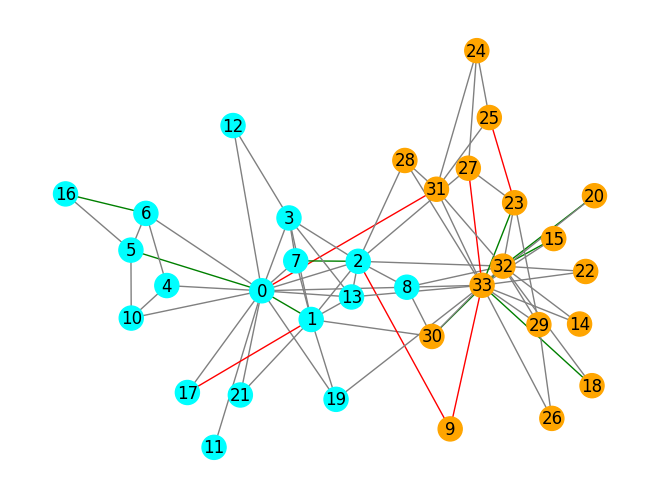

In [12]:
train_edges = set(G_train.edges())
edge_colors = []
for edge in G.edges():
    if edge in train_edges or (edge[1], edge[0]) in train_edges:
        edge_colors.append('grey')
    else:
        score = scores.get(edge, scores.get((edge[1], edge[0]), 0))
        if score > 0:
            edge_colors.append('green')
        else:
            edge_colors.append('red')

nx.draw(G, pos=pos, edge_color=edge_colors, with_labels=True, node_color=node_colors)
plt.show()

### Evaluation
A set of negative test edges (non-existent edges) is sampled, and Adamic-Adar scores are computed for both test (positive) and negative edges. These scores are used to compute and plot a Precision-Recall curve, evaluating how well the Adamic-Adar metric distinguishes between actual removed edges and random non-edges.

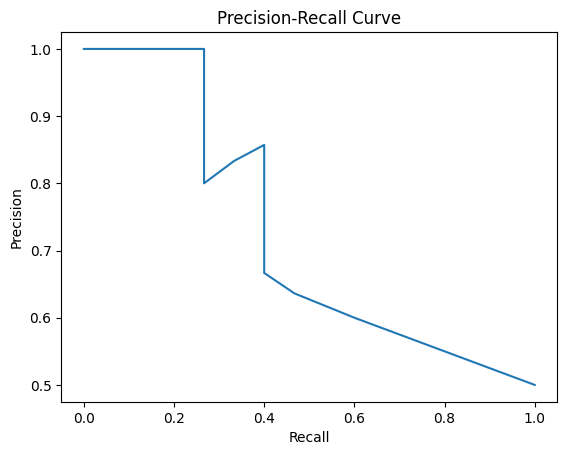

In [13]:
num_negatives = len(test_edges)
non_edges = list(nx.non_edges(G_train))
random.shuffle(non_edges)
neg_edges = non_edges[:num_negatives]

test_all = test_edges + neg_edges
aa_preds = nx.adamic_adar_index(G_train, test_all)
aa_scores = {(u, v): s for u, v, s in aa_preds}

y_true, y_score = [], []
for edge in test_edges:
    y_true.append(1)
    y_score.append(aa_scores.get(edge, aa_scores.get((edge[1], edge[0]), 0)))
for edge in neg_edges:
    y_true.append(0)
    y_score.append(aa_scores.get(edge, aa_scores.get((edge[1], edge[0]), 0)))

precision, recall, _ = precision_recall_curve(y_true, y_score)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()